In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Q3 API
from layers import dense 

In [4]:
dataset = np.load('a1_dataset.npz')
dataset.files

['x', 'y']

In [5]:
# 80-10-10 split for train, validate and test images
train_till = int(.8 * dataset['x'].shape[0])
validate_till = int(.9 * dataset['x'].shape[0])

print(train_till, validate_till-train_till, dataset['x'].shape[0]-validate_till)

# training dataset
x_train = dataset['x'][:train_till]/255
y_train = np.eye(96)[dataset['y'][:train_till]]

# validation dataset
x_val = dataset['x'][train_till:validate_till]/255
y_val = np.eye(96)[dataset['y'][train_till:validate_till]]

# testing dataset
x_test = dataset['x'][validate_till:]/255
y_test = np.eye(96)[dataset['y'][validate_till:]]

76800 9600 9600


In [6]:
n_classes = 96
n_features = 2352
batch_size = 800
epochs = 50
learning_rate = 0.3

In [7]:
# input
x_p = tf.placeholder(tf.float32, [None, n_features])
# output
y_p = tf.placeholder(tf.float32, [None, n_classes])

In [8]:
# define architecture
n_l1 = 128

# set up layers
hidden1 = dense(x=x_p, in_length=n_features, neurons=n_l1, activation=tf.nn.relu, layer_name='Layer_1', dev=0.1)
output = dense(x=hidden1, in_length=n_l1, neurons=n_classes, activation=tf.nn.softmax, layer_name='Layer_Output', dev=0.1)
y_clipped = tf.clip_by_value(output, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y_p * tf.log(y_clipped)+ (1 - y_p) * tf.log(1 - y_clipped), axis=1))

optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [9]:
prediction_vector = tf.argmax(y_p, 1)
output_vector = tf.argmax(output, 1)

In [10]:
acc, acc_op = tf.metrics.accuracy(prediction_vector, output_vector)

In [11]:
conmat = tf.confusion_matrix(prediction_vector, output_vector)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    avg_loss = []
    validate_accuracy = []
    total_batches = x_train.shape[0] // batch_size
    
    # Training
    for e in range(epochs):
        avg_loss.append(0.0)
        for b in range(total_batches):
            start = b*batch_size
            end = (b+1)*batch_size
            batch = sess.run([optimiser, cross_entropy], 
                     feed_dict={x_p: x_train[start:end], y_p: y_train[start:end]})
            avg_loss[e] += batch[1] / total_batches
        # validation
        accuracy = sess.run(acc_op,
                 feed_dict={x_p: x_val, y_p: y_val})
        validate_accuracy.append(accuracy)
        print("Epoch:","{:2d}".format(e+1), "train_loss =", "{:.4f}".format(avg_loss[e]), "validate_accuracy =", "{:.4f}".format(validate_accuracy[e]))
        
    # Testing
    test_accuracy, confusion_mat = sess.run([acc_op, conmat],
                    feed_dict={x_p:x_test, y_p:y_test})
    
    print('Testing Accuracy:', test_accuracy)
    print('Confusion Matrix:', confusion_mat)
    tf.io.write_graph(sess.graph_def, 'graphs/', 'line-v2.pbtxt')

Epoch:  1 train_loss = 5.1487 validate_accuracy = 0.0901
Epoch:  2 train_loss = 4.5501 validate_accuracy = 0.1242
Epoch:  3 train_loss = 4.1361 validate_accuracy = 0.1595
Epoch:  4 train_loss = 3.7643 validate_accuracy = 0.1924
Epoch:  5 train_loss = 3.4517 validate_accuracy = 0.2217
Epoch:  6 train_loss = 3.1921 validate_accuracy = 0.2485
Epoch:  7 train_loss = 2.9710 validate_accuracy = 0.2737
Epoch:  8 train_loss = 2.7756 validate_accuracy = 0.2971
Epoch:  9 train_loss = 2.5999 validate_accuracy = 0.3190
Epoch: 10 train_loss = 2.4412 validate_accuracy = 0.3398
Epoch: 11 train_loss = 2.2965 validate_accuracy = 0.3600
Epoch: 12 train_loss = 2.1648 validate_accuracy = 0.3793
Epoch: 13 train_loss = 2.0423 validate_accuracy = 0.3977
Epoch: 14 train_loss = 1.9307 validate_accuracy = 0.4152
Epoch: 15 train_loss = 1.8282 validate_accuracy = 0.4320
Epoch: 16 train_loss = 1.7327 validate_accuracy = 0.4480
Epoch: 17 train_loss = 1.6450 validate_accuracy = 0.4633
Epoch: 18 train_loss = 1.5646 v

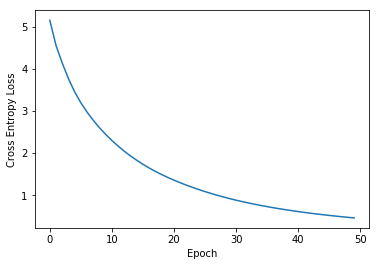

In [13]:
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(avg_loss[None:])
plt.show()

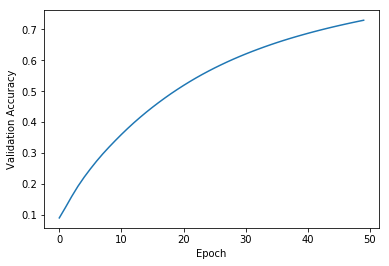

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.plot(validate_accuracy)
plt.show()

In [15]:
True_positives = np.diag(confusion_mat)
False_positives = np.sum(confusion_mat, axis=1) - True_positives
False_negatives = np.sum(confusion_mat, axis=0) - True_positives
Precision = True_positives / (True_positives + False_positives)
print("Precision:", Precision)
Recall = True_positives / (True_positives + False_negatives)
print("\nRecall:", Recall)
F_scores = (2*Precision*Recall) / (Recall+Precision)
print("\nF_scores:", F_scores)

Precision: [0.64545455 0.58947368 0.86734694 0.96969697 0.7012987  0.84210526
 0.88888889 0.48809524 0.81981982 1.         0.66       0.43157895
 0.75728155 0.5        0.93137255 0.98795181 0.78899083 0.53684211
 0.94117647 0.44859813 0.93965517 1.         0.51111111 0.73033708
 0.93859649 0.92045455 0.98863636 1.         1.         0.99107143
 1.         0.97826087 0.98333333 1.         0.98989899 0.97
 0.94339623 0.90909091 1.         0.98214286 0.98989899 1.
 0.9875     1.         1.         0.98       0.99130435 0.97916667
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99122807 0.99082569 0.98198198 0.98969072
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99038462 1.         0.98989899 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1

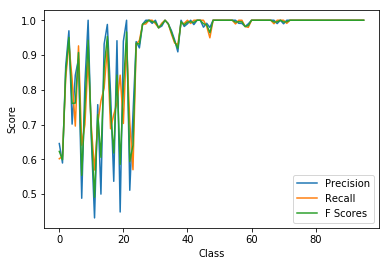

In [16]:
plt.plot(Precision, label='Precision')
plt.plot(Recall, label='Recall')
plt.plot(F_scores, label='F Scores')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend()
plt.show()

In [17]:
np.savez_compressed('linev2-conmat.npz', cmat=confusion_mat)